In [4]:
import numpy as np
import copy
from astropy.io import fits
from importlib import reload
import matplotlib.pyplot as plt
plt.rcParams['image.origin']='lower'
import os
from pathlib import Path
from datetime import datetime
date = int(datetime.today().strftime('%Y%m%d'))

import proper
proper.use_ffti = False
proper.use_fftw = False

import roman_phasec_proper as phasec
phasec.copy_here()
import falco

from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

falco_dir = Path(os.path.dirname(falco.__file__))
roman_dir = Path(os.path.dirname(falco_dir))/'roman'
flatmap_dir = roman_dir/'flatmaps'

import misc
from imshows import *

import falco_hlc_575_mp
import phase_retrieval as pr

mp = falco_hlc_575_mp.mp

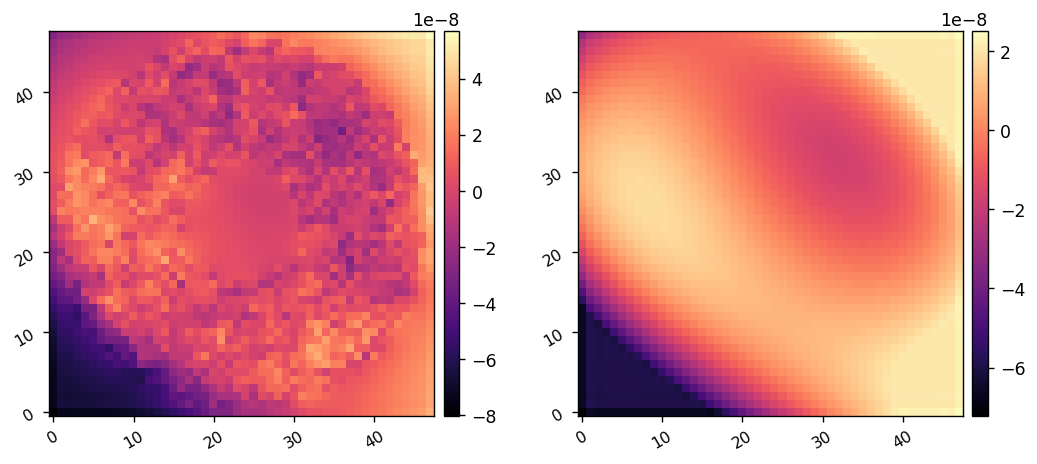

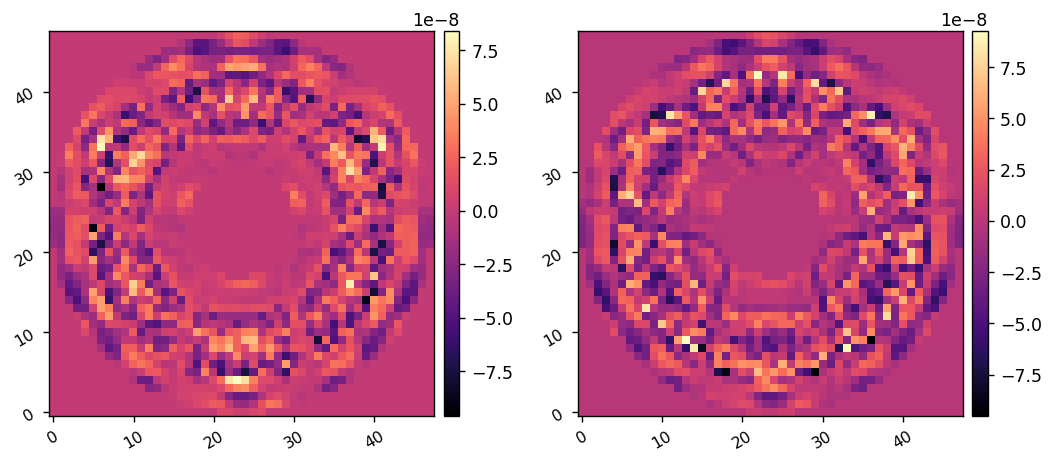

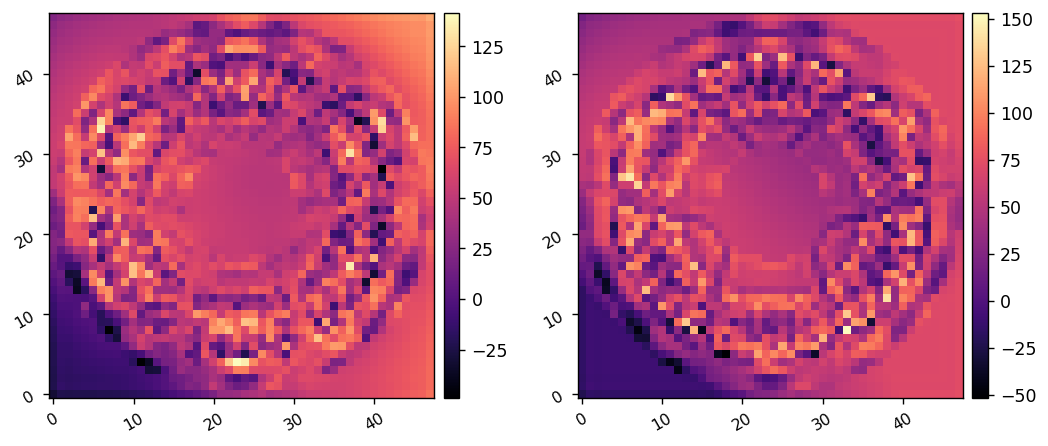

In [2]:
# DM starting voltages (in the PROPER model only)
fn_dm1_design = os.path.join(str(flatmap_dir), 'dm1_m_design_hlc_band1.fits')
fn_dm2_design = os.path.join(str(flatmap_dir), 'dm2_m_design_hlc_band1.fits')
fn_dm1_flatmap = os.path.join(str(flatmap_dir), 'dm1_m_flat_hlc_band1.fits')
fn_dm2_flatmap = os.path.join(str(flatmap_dir), 'dm2_m_flat_hlc_band1.fits')
mp.full.dm1 = falco.config.Object()
mp.full.dm2 = falco.config.Object()

dm1_hlc_flatmap = fits.getdata(fn_dm1_flatmap)
dm2_hlc_flatmap = fits.getdata(fn_dm2_flatmap)
imshow2(dm1_hlc_flatmap, dm2_hlc_flatmap)

dm1_hlc_design = fits.getdata(fn_dm1_design)
dm2_hlc_design = fits.getdata(fn_dm2_design)
imshow2(dm1_hlc_design, dm2_hlc_design)

mp.full.dm1.flatmap = dm1_hlc_flatmap + dm1_hlc_design
mp.full.dm2.flatmap = dm2_hlc_flatmap + dm2_hlc_design

mp.dm1.biasMap = 50 + mp.full.dm1.flatmap/mp.dm1.VtoH  # Bias voltage. Needed prior to WFSC to allow + and - voltages. Total voltage is mp.dm1.biasMap + mp.dm1.V
mp.dm2.biasMap = 50 + mp.full.dm2.flatmap/mp.dm2.VtoH  # Bias voltage. Needed prior to WFSC to allow + and - voltages. Total voltage is mp.dm2.biasMap + mp.dm2.V
imshow2(mp.dm1.biasMap, mp.dm2.biasMap)


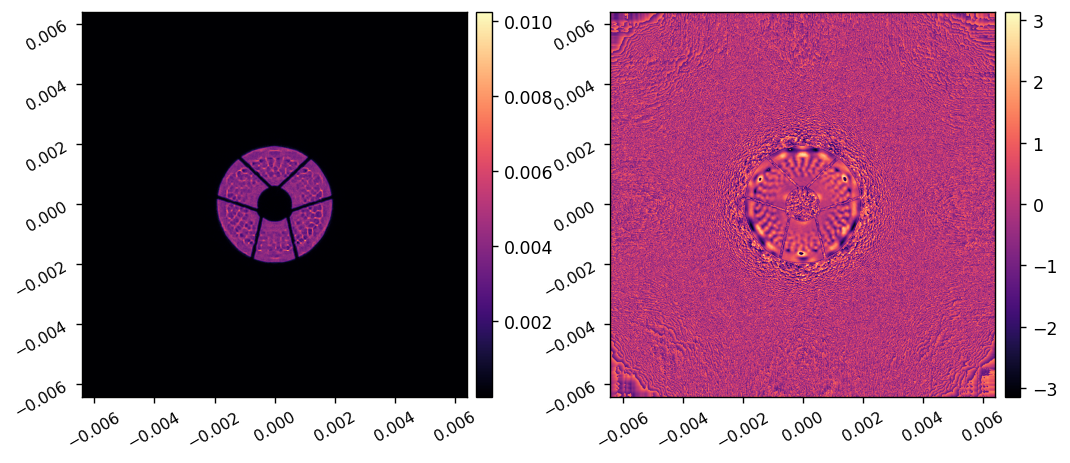

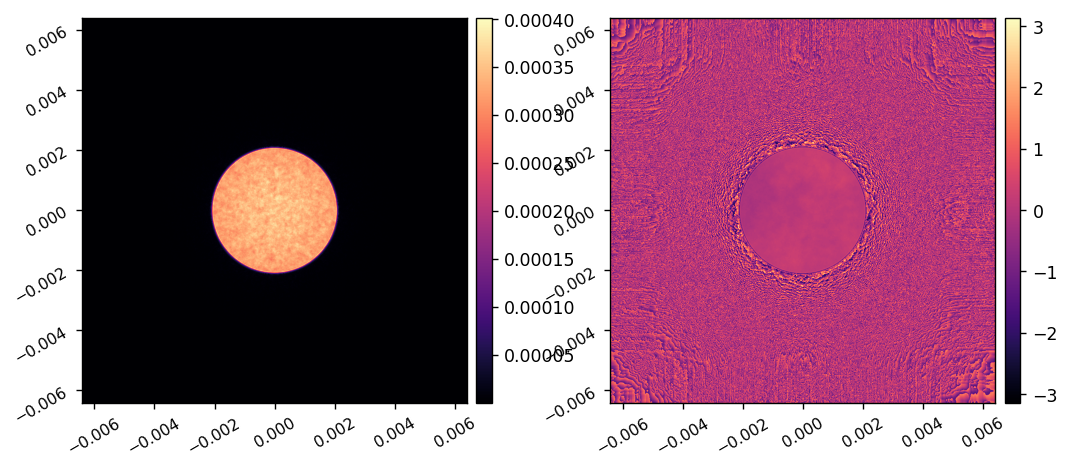

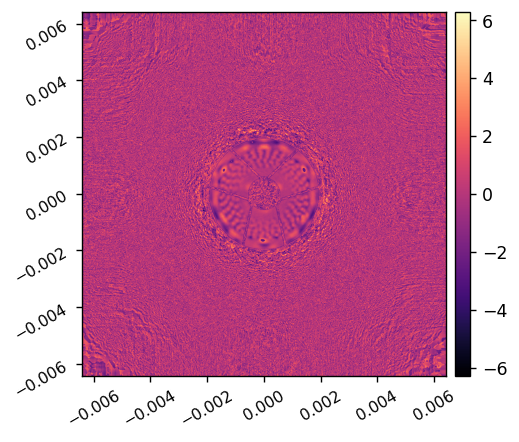

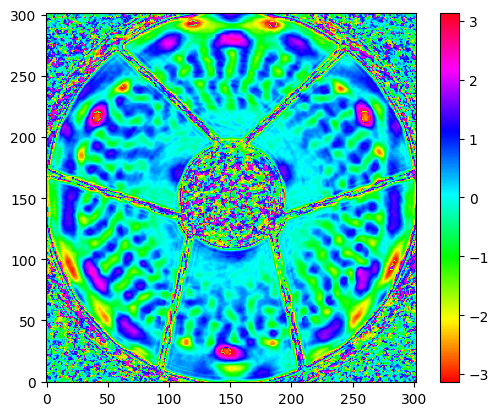

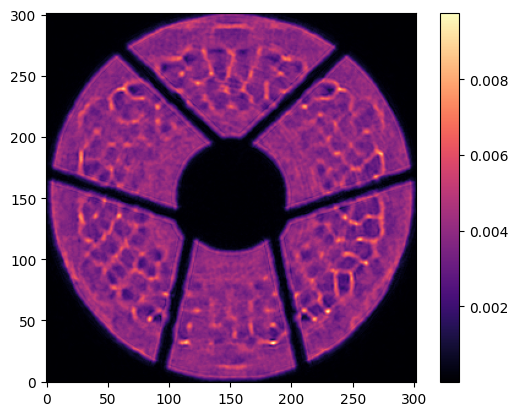

In [4]:
mp = pr.ipr(mp)

hlc_575_test
 Using 1 discrete wavelength(s) in each of 1 sub-bandpasses over a 1.0% total bandpass 

Sub-bandpasses are centered at wavelengths [nm]:	 [575.]


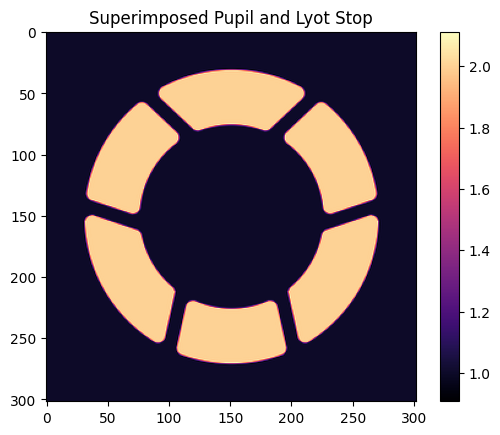

  Influence function padded from 84 to 84 points for A.S. propagation.
Computing datacube of DM influence functions... done.
  Influence function padded from 84 to 84 points for A.S. propagation.
Computing datacube of DM influence functions... done.


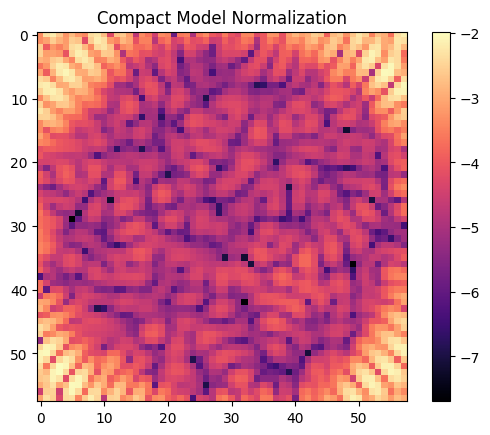

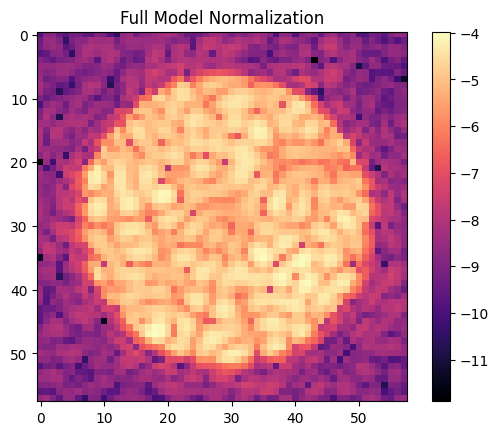


Beginning Trial 1 of Series 1.

DM 1-to-2 Fresnel number (using radius) = 932.0391304347827


In [20]:
# Record Keeping
mp.runLabel = ('hlc_575_test')
print(mp.runLabel)
mp.TrialNum = 1
mp.SeriesNum = 1

out = falco.setup.flesh_out_workspace(mp)


In [ ]:
# %% Perform the Wavefront Sensing and Control
falco.wfsc.loop(mp, out)
misc.save_pickle(mp.runLabel + '_mp.pkl', mp)
misc.save_pickle(mp.runLabel + '_out.pkl', out)

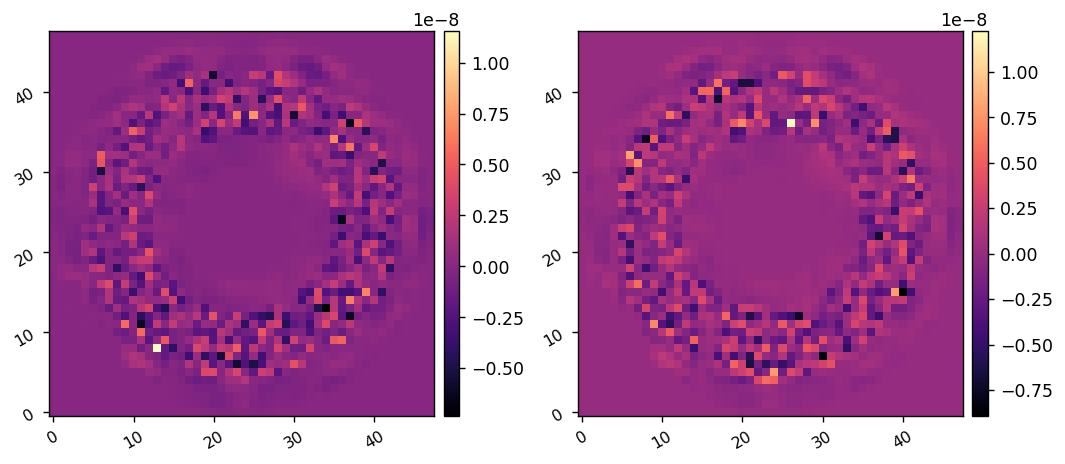

In [6]:
imshow2(mp.dm1.V * mp.dm1.VtoH, mp.dm2.V * mp.dm2.VtoH)

In [5]:
mp = misc.load_pickle('hlc_575_test_mp.pkl')
out = misc.load_pickle('hlc_575_test_out.pkl')

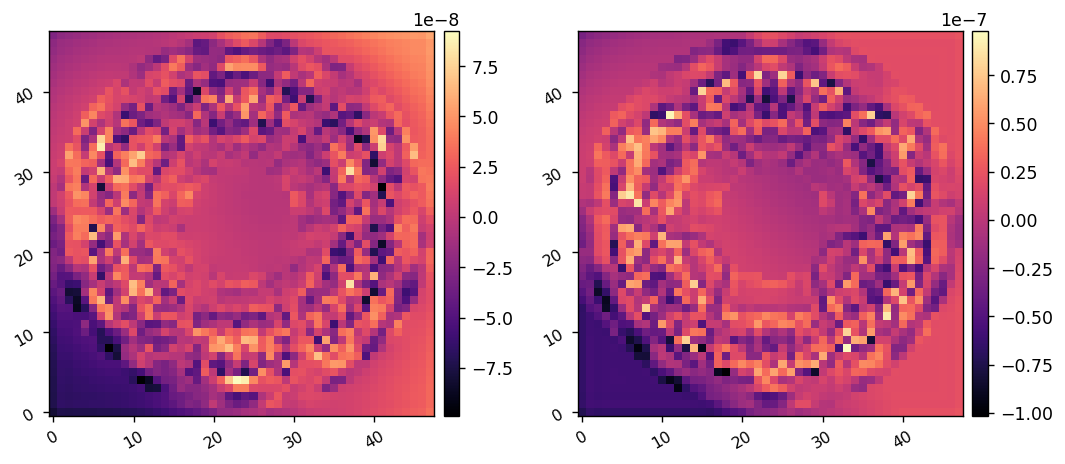

In [11]:
dm1_m = out.dm1.Vall[:,:,-1]*mp.dm1.VtoH + mp.full.dm1.flatmap
dm2_m = out.dm2.Vall[:,:,-1]*mp.dm2.VtoH + mp.full.dm2.flatmap
imshow2(dm1_m, dm2_m)

In [13]:
options = {'cor_type':mp.full.cor_type,
           'final_sampling_lam0':mp.full.final_sampling_lam0, 
           'source_x_offset':0,
           'use_errors': mp.full.use_errors,
#            'use_lens_errors':mp.full.use_lens_errors,
           'use_dm1':1, 'dm1_m':dm1_m, 
           'use_dm2':1, 'dm2_m':dm2_m,
#            'use_field_stop':mp.full.use_field_stop, 
           'field_stop_radius_lam0': mp.full.field_stop_radius_lam0,
           'polaxis':mp.full.polaxis,
          }

In [14]:
lambda_um = mp.lambda0*1e6
npsf = 64

psf, sampling = proper.prop_run('roman_phasec', lambda_um, npsf, QUIET=False, PASSVALUE=options)

Lambda = 5.7500E-07   Throughput = 1.00
Applying lens
Propagating to secondary
Applying lens
Propagating to POMA FOLD
Propagating to M3
Applying lens
Propagating to M4
Applying lens
Propagating to M5
Applying lens
Propagating to TT FOLD
Propagating to FSM
Propagating to OAP1
Applying lens
Propagating to FOCM
Propagating to OAP2
Applying lens
Propagating to DM1
Propagating to DM2
Propagating to OAP3
Applying lens
Propagating to FOLD_3
Propagating to OAP4
Applying lens
Propagating to PUPIL_MASK
Propagating to OAP5
Applying lens
Propagating to FPM
Propagating to OAP6
Applying lens
Propagating to LYOT STOP
Propagating to OAP7
Applying lens
Propagating to FIELD_STOP
Propagating to OAP8
Applying lens
Propagating to filter
Propagating to IMAGING LENS
Applying lens at IMAGING LENS lens #1
Propagating
Applying lens at IMAGING LENS lens #2
Propagating to IMAGE
Total elapsed time (seconds) =  17.1816


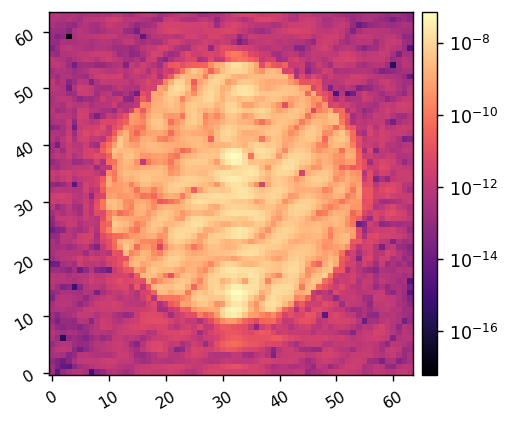

In [15]:
imshow1(np.abs(psf)**2, lognorm=True)